## To-do
- Now that we have import and metadata extraction working, we need to start preprocessing (mostly interpolating timepoints for z-slices if recorded on frame-by-frame basis by the scope) and some scheme for identification of a nuclear and a spot channel that is compatible with switching between the two channels (e.g. using mCherry to segment nuclei during cycles but not at the division).
- Makes sense to use dask for visualization (e.g. choosing a threshold).
- Write DoG/segmentation fuction so that it can take either 2D or 3D data - give the option to segment off of a projection, or off of raw 3D data.
    - Write in options for DoG and LoG segmentation algorithm with standard nuclear sizes vs box DoG/LoG vs watershed.

In [1]:
import preprocessing.import_data as im

trim_series = True
lif_test_name = "test_data/2021-06-14/p2pdpwt"
lsm_test_name = "test_data/2023-04-07/p2pdp_zld-sites-ctrl_fwd_1"

(
    channels_full_dataset,
    original_global_metadata,
    original_frame_metadata,
    export_global_metadata,
    export_frame_metadata,
) = im.import_save_dataset(lsm_test_name, trim_series)

/home/ybadal/mambaforge/envs/transcription_pipeline/lib/python3.10/site-packages/pims/bioformats.py:410: UserWarning: Due to an issue with JPype 0.6.0, reading is slower. Please consider upgrading JPype to 0.6.1 or later.
  warn('Due to an issue with JPype 0.6.0, reading is slower. '
/home/ybadal/mambaforge/envs/transcription_pipeline/lib/python3.10/site-packages/scipy/io/matlab/_mio5.py:493: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  narr = np.asanyarray(source)


In [2]:
import napari
import matplotlib.pyplot as plt
import numpy as np

In [5]:
import dask.array as da
image = nuclear_channel[40:50]
nuclear_test = da.from_array(image, chunks=image.shape)

In [6]:
nuclear_channel = channels_full_dataset[1]

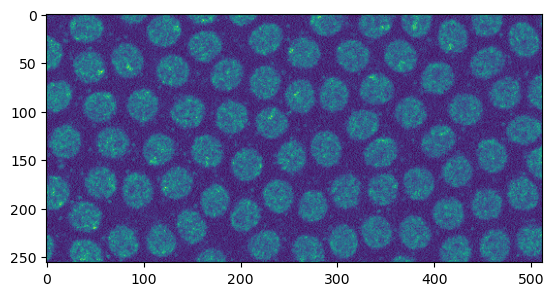

In [7]:
plt.imshow(nuclear_test[5][12])

In [8]:
viewer = napari.view_image(nuclear_test, name='Nuclear Channel')
napari.run()

In [9]:
from skimage.filters import difference_of_gaussians

In [11]:
dog_filtered = da.stack([difference_of_gaussians(nuclear_test, high_sigma=t, low_sigma=3) for t in np.arange(4, 100)])

In [ ]:
plt.imshow(dog_filtered[12])

In [12]:
viewer.add_image(dog_filtered,
    name='dog_filtered', colormap='magenta', blending='additive'
)

<Image layer 'dog_filtered' at 0x7f61301408e0>